In [2]:
import numpy as np

In [20]:
from meshpy.tet import MeshInfo, build
import meshpy.triangle as triangle

In [43]:
H = 7
W = 3
S = 20

points = [(250, -2*S - H), (100 - H, -2*S - H),
         (100 - H, -S), (150 - H, -S),(150 - H, -H),
         (0,-H), (0,0), (150,0), (150,-S - H),
         (100, -S - H), (100, -2*S), (250, -2*S)]

def round_trip_connect(start, end):
    result = []
    for i in range(start, end):
        result.append((i, i + 1))
    result.append((end, start))
    return result

facets = round_trip_connect(0, len(points) - 1)
mesh_info = triangle.MeshInfo()
mesh_info.set_points(points)
mesh_info.set_facets(facets)
mesh = triangle.build(mesh_info, max_volume=H, min_angle=25)
# print("Mesh Points:")
# for i, p in enumerate(mesh.points):
#     print(i, p)
print("Point numbers in tetrahedra:")
for i, t in enumerate(mesh.elements):
    print(i, t)
triangle.write_gnuplot_mesh('test2.vtk', mesh)

Point numbers in tetrahedra:
0 [200, 206, 209]
1 [80, 81, 84]
2 [282, 325, 281]
3 [193, 183, 195]
4 [61, 66, 0]
5 [113, 116, 112]
6 [358, 364, 356]
7 [345, 348, 347]
8 [217, 2, 208]
9 [162, 152, 156]
10 [313, 319, 318]
11 [178, 23, 163]
12 [397, 402, 398]
13 [73, 72, 75]
14 [261, 3, 256]
15 [4, 271, 273]
16 [293, 284, 287]
17 [125, 119, 121]
18 [31, 305, 304]
19 [239, 240, 245]
20 [140, 145, 35]
21 [379, 380, 376]
22 [48, 70, 50]
23 [60, 55, 63]
24 [104, 105, 108]
25 [87, 88, 17]
26 [301, 42, 306]
27 [346, 347, 348]
28 [286, 295, 297]
29 [307, 310, 314]
30 [420, 418, 44]
31 [420, 401, 405]
32 [128, 125, 45]
33 [140, 35, 138]
34 [47, 60, 63]
35 [60, 48, 54]
36 [116, 39, 112]
37 [80, 77, 81]
38 [282, 281, 285]
39 [281, 325, 13]
40 [118, 14, 122]
41 [289, 295, 294]
42 [308, 314, 310]
43 [416, 407, 417]
44 [55, 37, 63]
45 [46, 54, 48]
46 [24, 48, 62]
47 [38, 53, 51]
48 [50, 46, 48]
49 [48, 24, 52]
50 [52, 67, 70]
51 [67, 51, 53]
52 [24, 51, 52]
53 [69, 25, 67]
54 [51, 67, 52]
55 [52, 70, 4

In [25]:
import matplotlib.pyplot as plt

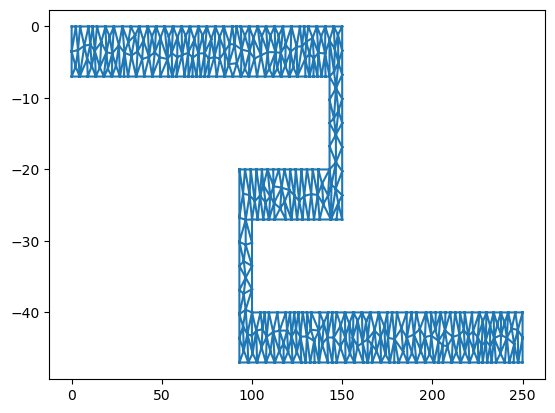

In [46]:
plt.triplot(test_x_f, test_y_f, triangles)

In [44]:
points = np.array(mesh.points)
test_x_f = points[:,0]
test_y_f = points[:,1]

In [45]:
triangles = np.array(mesh.elements)